# Hessian Analysis
In this notebook we explore the hessian metrics with quantized models.

In [20]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import pickle

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from hessian import Hessian

### Utility methods

In [21]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def read_file(file_path, name='hessian', j_reg=0.0, aug_percentage=0.0, prune=0.0):
    
    if j_reg > 0:
        name = f"{name}_jreg_{j_reg}"
    elif prune > 0:
        name = f"{name}_prune_{prune}"
    elif aug_percentage > 0:
        name = f"{name}_aug_{aug_percentage}"
        
    file_path = os.path.join(file_path, f'{name}.pkl')
    
    try:
        with open(file_path, 'rb') as f:
            result = pickle.load(f)
        return result[name]
    except FileNotFoundError:
        print(f"File not found. ({file_path})")
    except Exception as e:
        print("Error occurred:", e)

In [22]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# ECON model (Autoencoder)

In [23]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'

----------------------------------------------------------------------------------------------------


/tmp/tbaldi/ipykernel_3166070/4045121449.py:34: RuntimeWarning: divide by zero encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/4045121449.py:34: RuntimeWarning: invalid value encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/4045121449.py:35: RuntimeWarning: divide by zero encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
/tmp/tbaldi/ipykernel_3166070/4045121449.py:35: RuntimeWarning: invalid value encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)


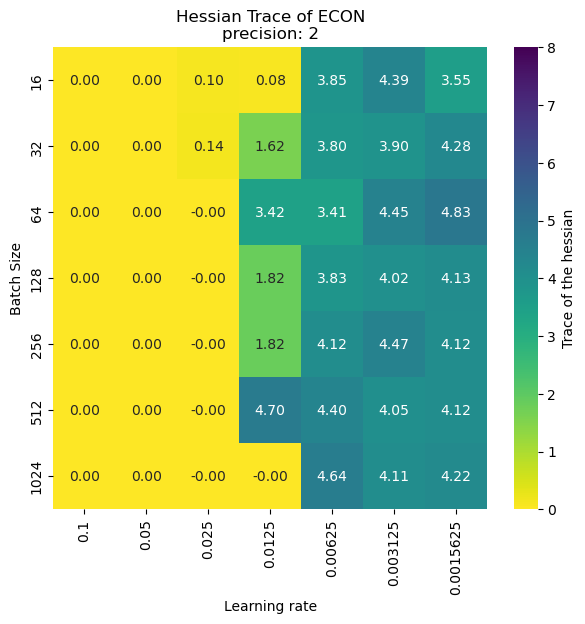

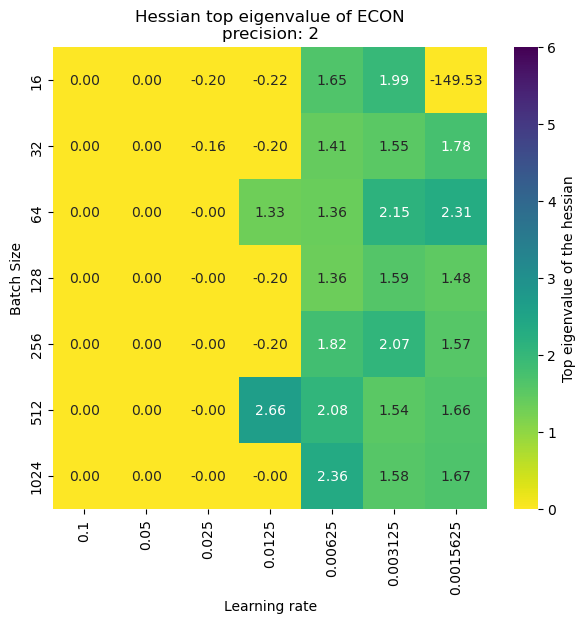

----------------------------------------------------------------------------------------------------


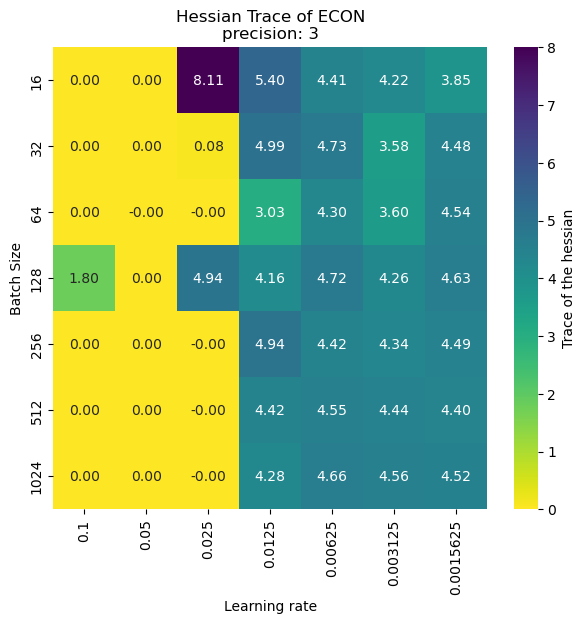

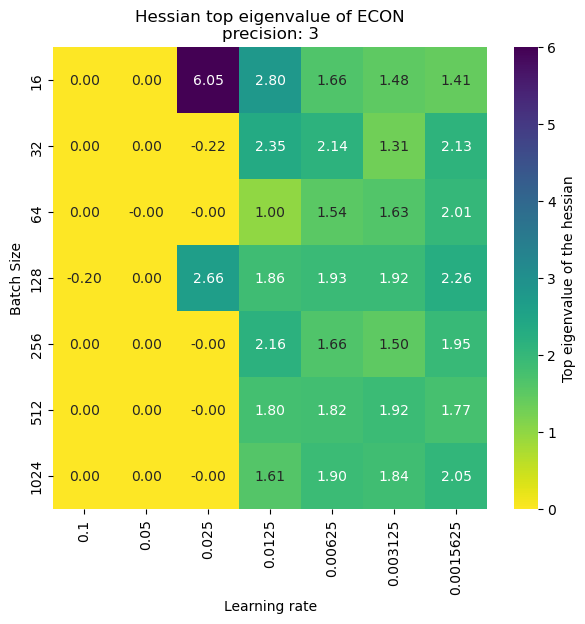

----------------------------------------------------------------------------------------------------


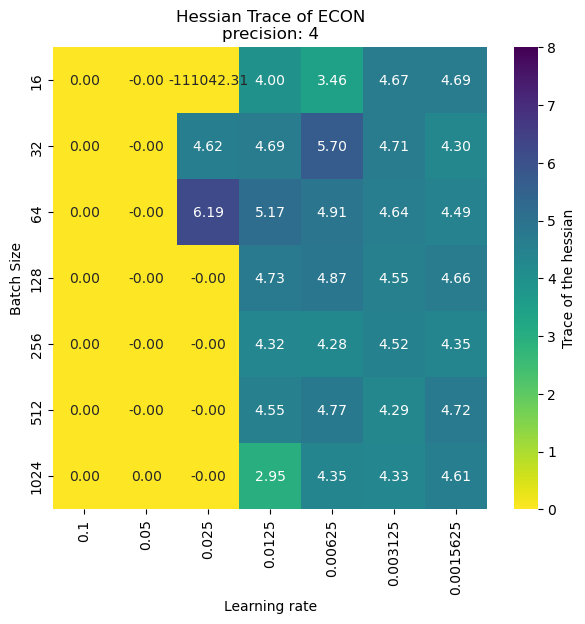

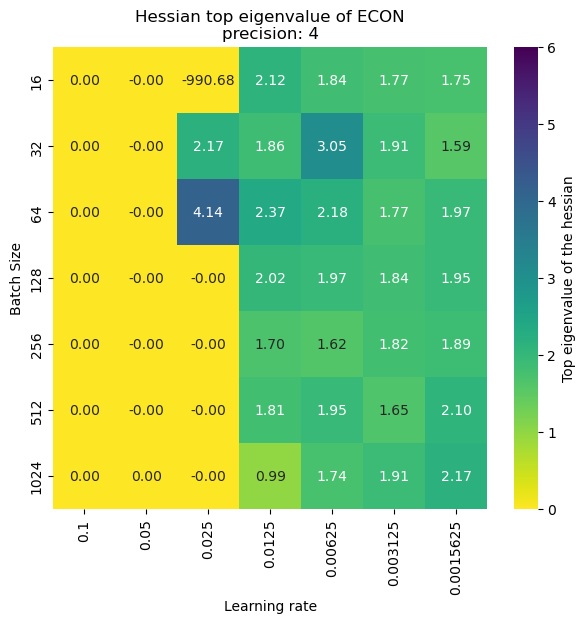

----------------------------------------------------------------------------------------------------


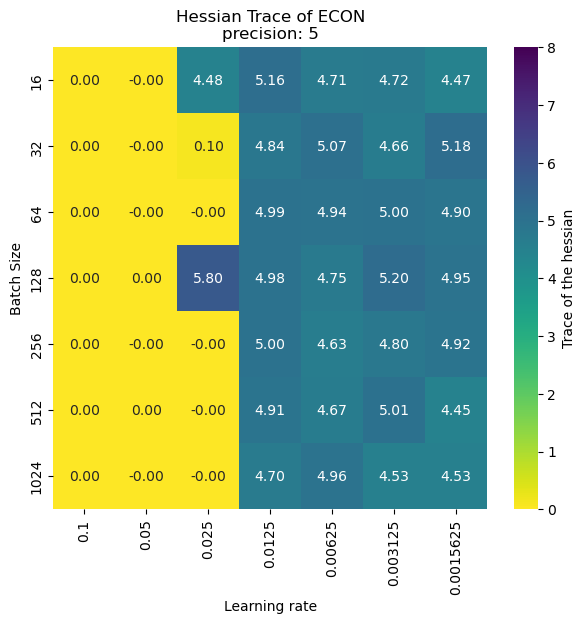

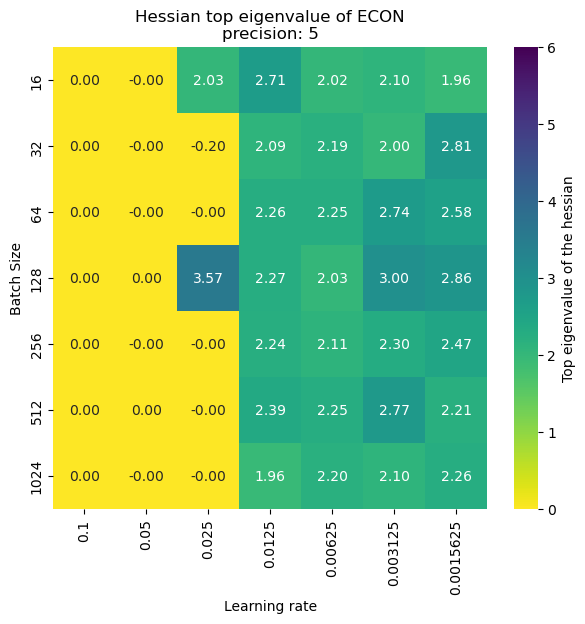

----------------------------------------------------------------------------------------------------


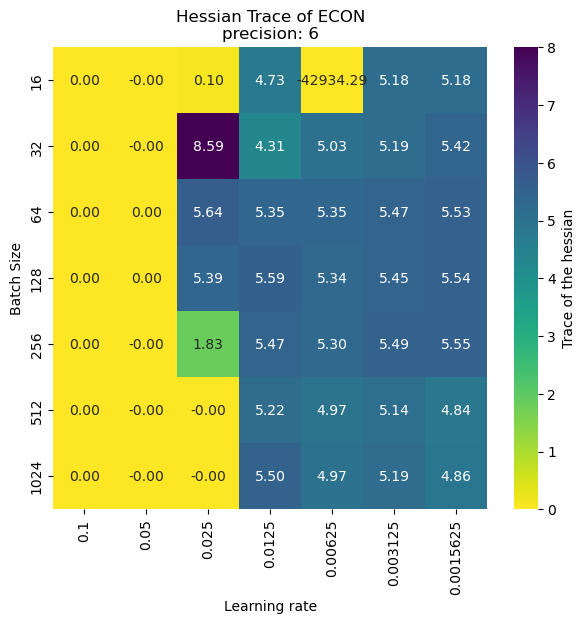

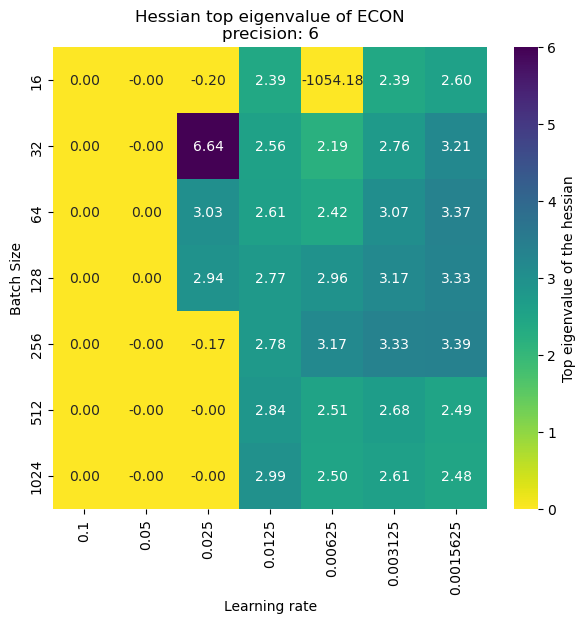

----------------------------------------------------------------------------------------------------


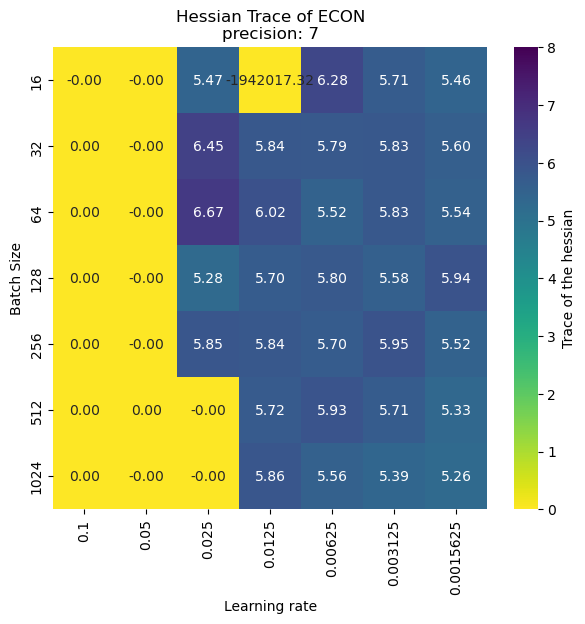

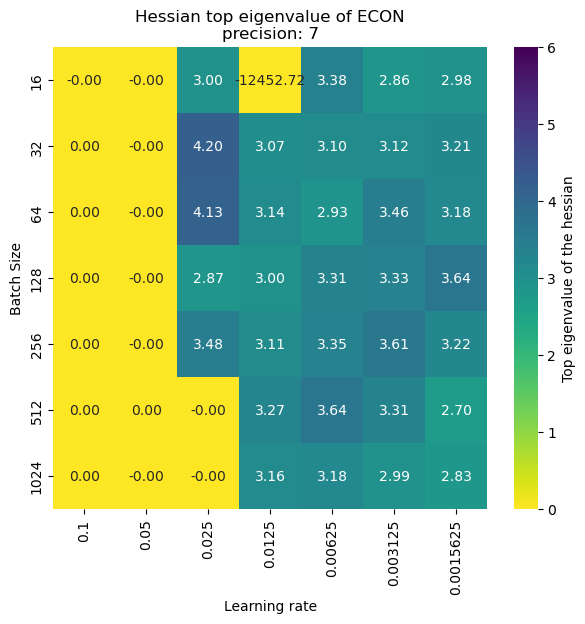

----------------------------------------------------------------------------------------------------


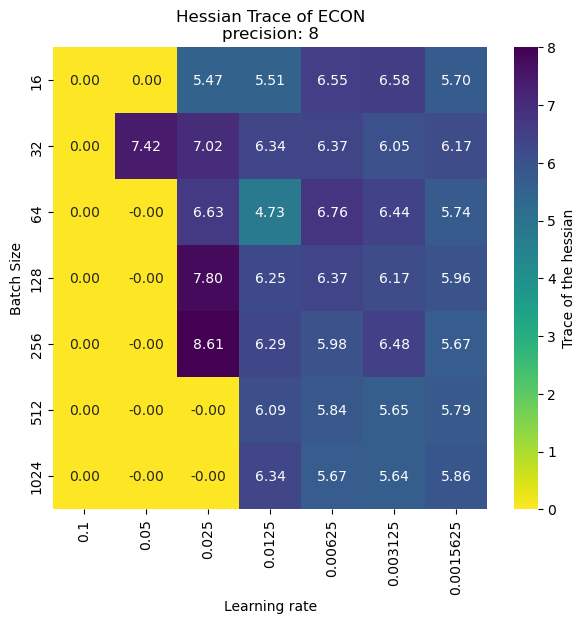

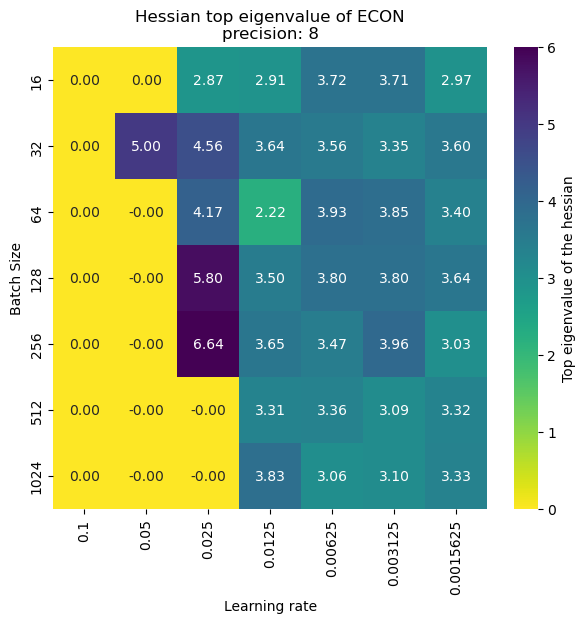

----------------------------------------------------------------------------------------------------


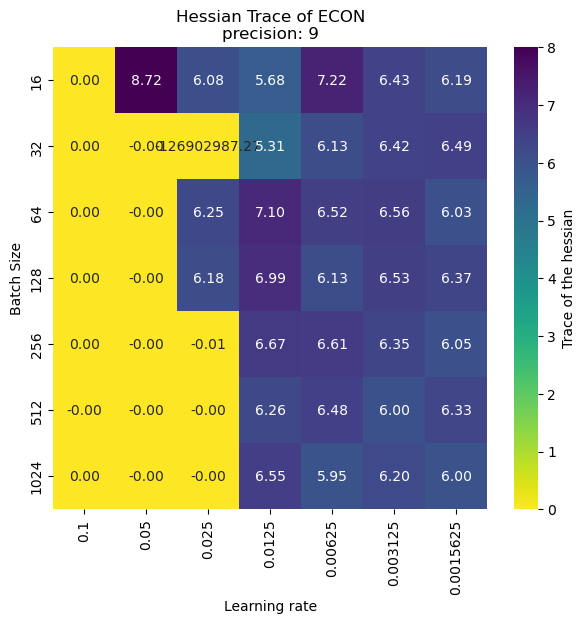

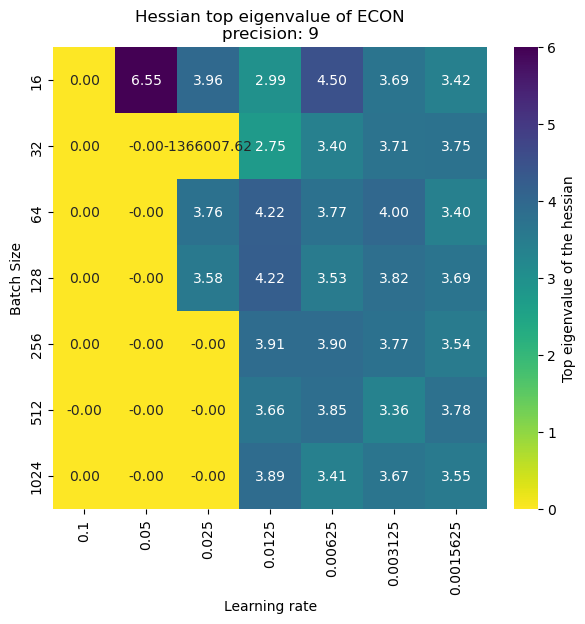

----------------------------------------------------------------------------------------------------


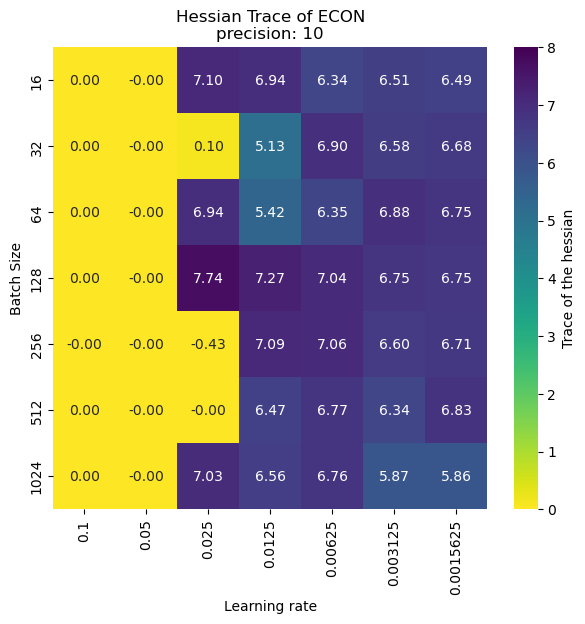

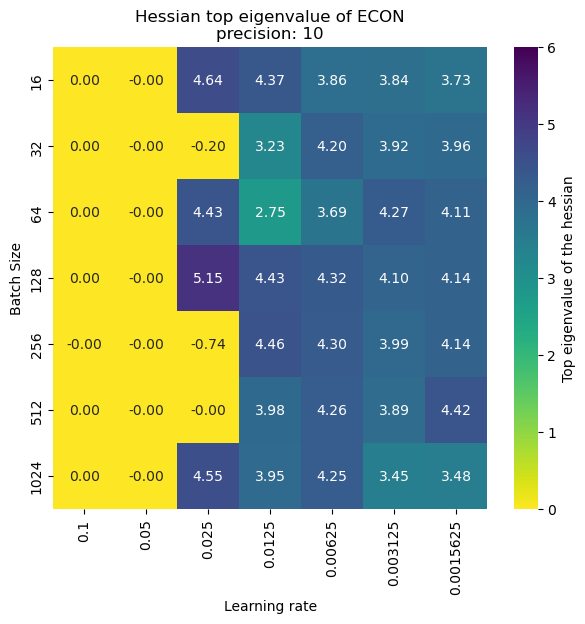

----------------------------------------------------------------------------------------------------


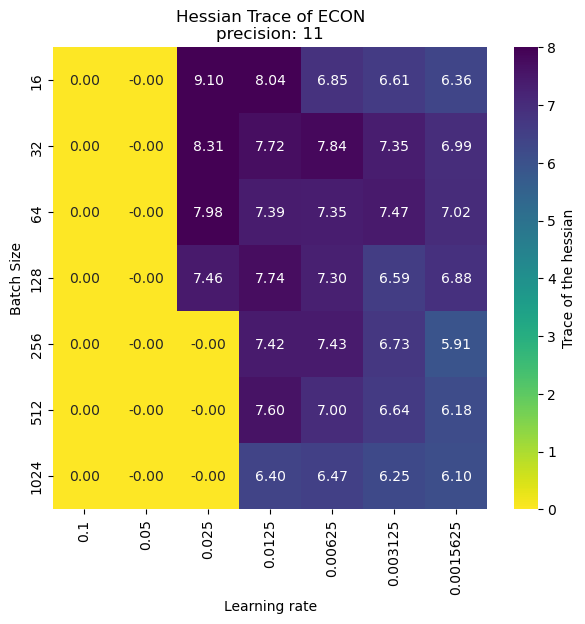

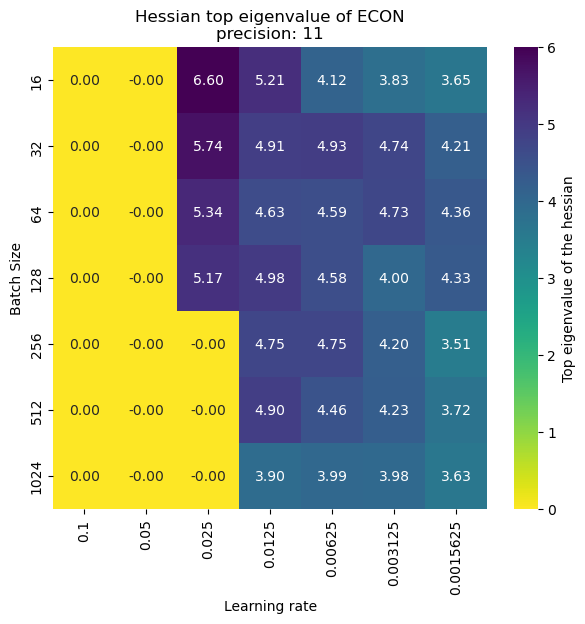

In [24]:
hessian_distribution = []
for p in precisions:
    trace_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    eigen_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')

            result = -1
            trace = []
            eigen_value = []
            try:
                for i in range(1, 4):
                    result = read_file(path, name=f"hessian_{i}")
                    trace.append(sum(result['trace']))
                    eigen_value.append(result['eigenvalues'][0])
            except:
                print("Error: cannot open the file!")
                
            trace_matrix[x, y] = -1
            eigen_matrix[x, y] = -1
            if len(trace) > 0:
                trace_matrix[x, y] = mean(trace)
                eigen_matrix[x, y] = mean(eigen_value)
            
            hessian_distribution.append({
                'precision': p, 
                'trace': trace_matrix[x, y],
                'eigenvalue': eigen_matrix[x, y],
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
    log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
    
    log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    
    print('-'*100)
    
    plot_2d_heatmap(log_trace_matrix, 
                    f'Hessian Trace of ECON\nprecision: {p}', 
                    (0, 8),
                    'Learning rate',
                    'Batch Size',
                    'Trace of the hessian',
                    cmap='viridis_r')
    
    
    plot_2d_heatmap(log_eigen_matrix, 
                    f'Hessian top eigenvalue of ECON\nprecision: {p}', 
                    (0, 6),
                    'Learning rate',
                    'Batch Size',
                    'Top eigenvalue of the hessian',
                    cmap='viridis_r')
            
            

In [25]:
hessian_distribution_df = pd.DataFrame(hessian_distribution)
hessian_distribution_df.to_csv("./results/econ/hessian.csv", index=False)

----------------------------------------------------------------------------------------------------


/tmp/tbaldi/ipykernel_3166070/88127013.py:24: RuntimeWarning: divide by zero encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/88127013.py:24: RuntimeWarning: invalid value encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/88127013.py:25: RuntimeWarning: divide by zero encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
/tmp/tbaldi/ipykernel_3166070/88127013.py:25: RuntimeWarning: invalid value encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)


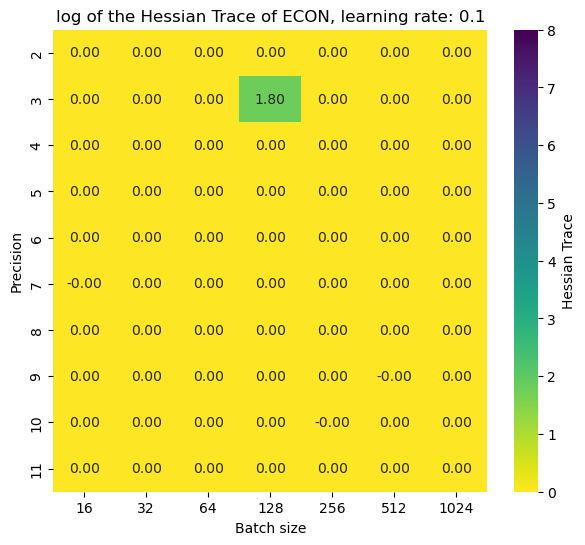

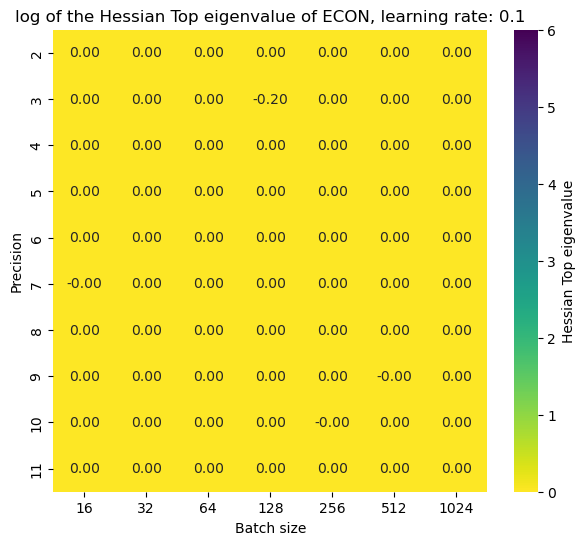

----------------------------------------------------------------------------------------------------


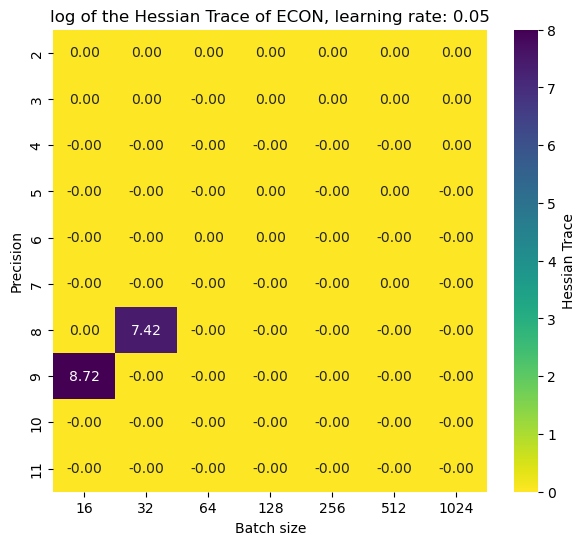

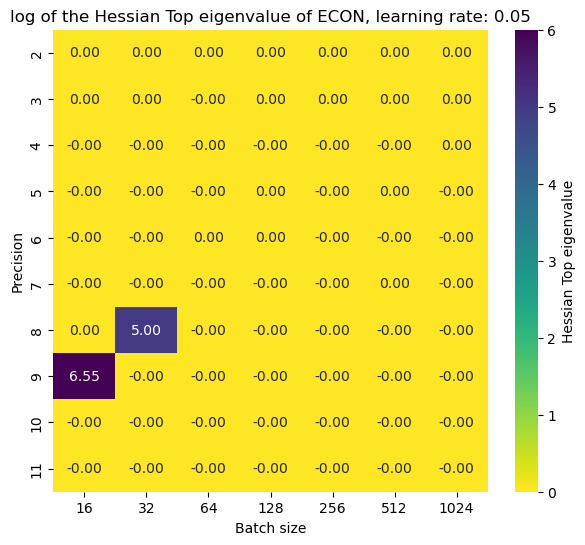

----------------------------------------------------------------------------------------------------


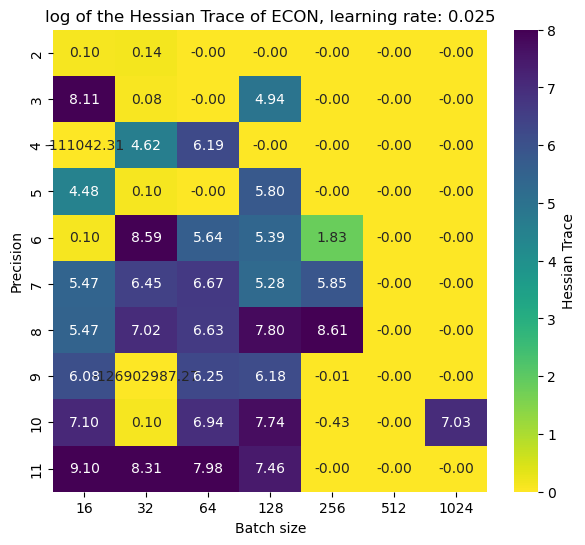

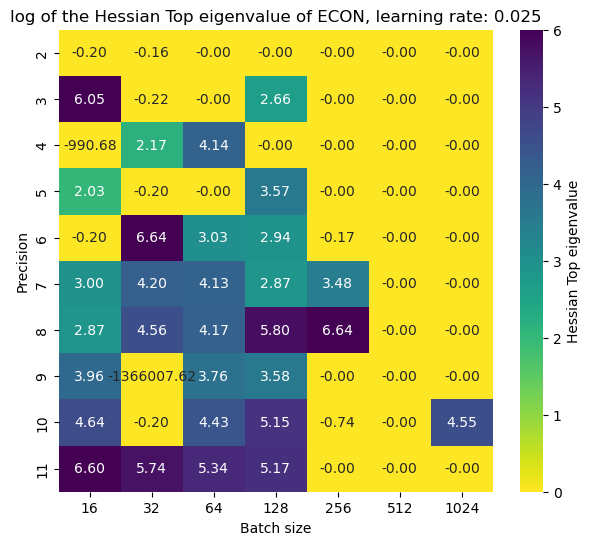

----------------------------------------------------------------------------------------------------


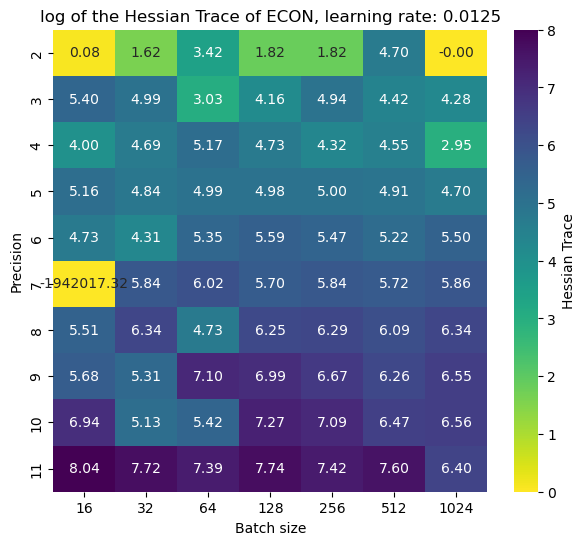

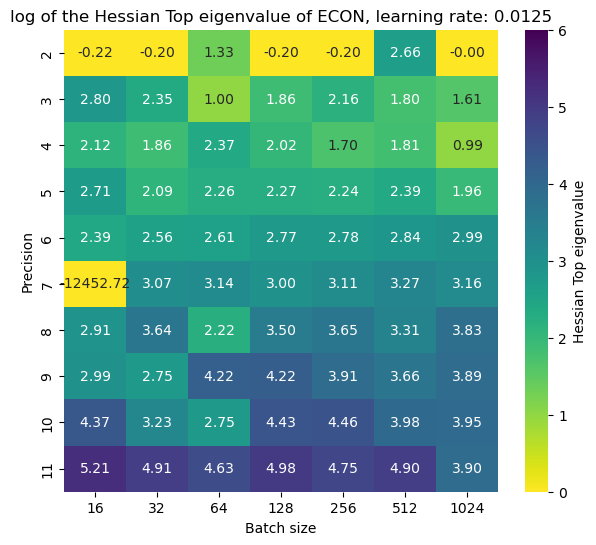

----------------------------------------------------------------------------------------------------


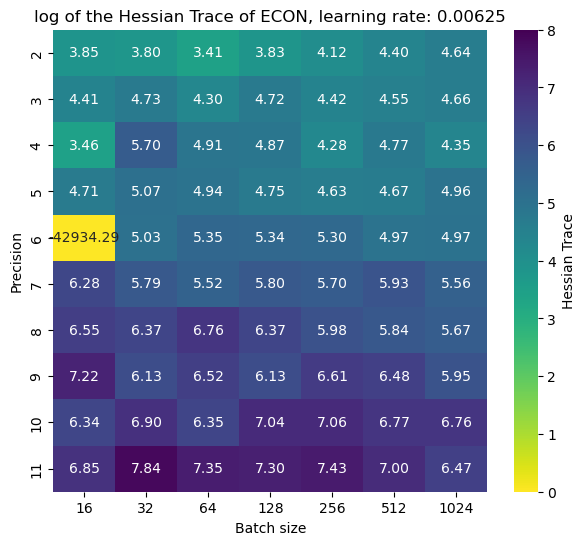

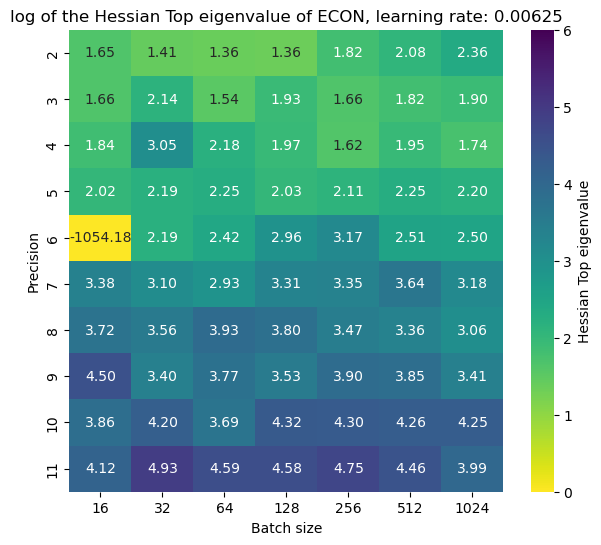

----------------------------------------------------------------------------------------------------


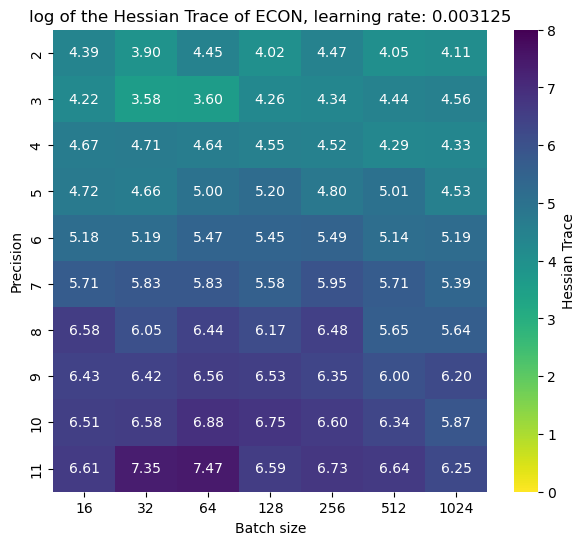

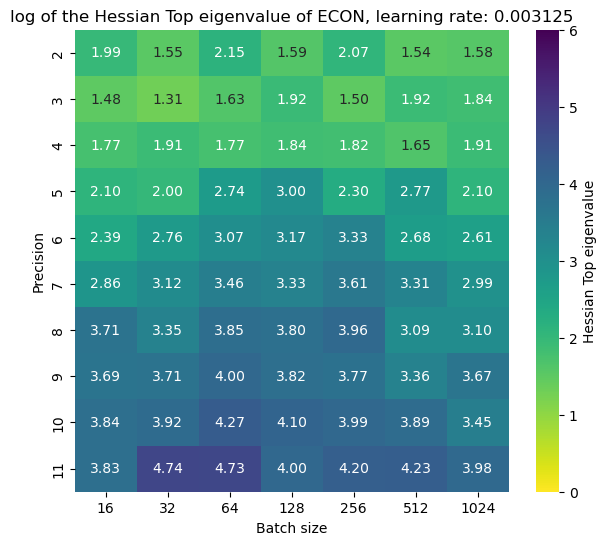

----------------------------------------------------------------------------------------------------


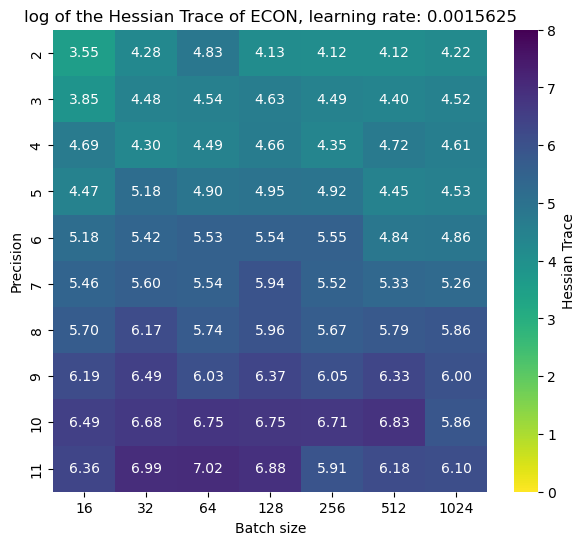

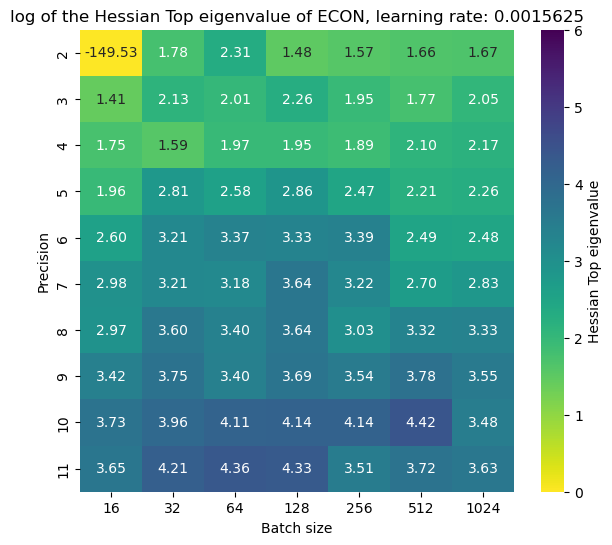

In [26]:
for lr in learning_rates:
    trace_matrix = np.zeros((len(precisions), len(batch_sizes)))
    eigen_matrix = np.zeros((len(precisions), len(batch_sizes)))
    for y, bs in enumerate(batch_sizes):
        for x, p in enumerate(precisions):

            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')

            result = -1
            trace = []
            eigen_value = []
            try:
                for i in range(1, 4):
                    result = read_file(path, name=f"hessian_{i}")
                    trace.append(sum(result['trace']))
                    eigen_value.append(result['eigenvalues'][0])
            except:
                print("Error: cannot open the file!")
                
            trace_matrix[x, y] = mean(trace)
            eigen_matrix[x, y] = mean(eigen_value)
                
            
    log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
    log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
    
    log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                    index=precisions, 
                                    columns=batch_sizes)
    log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                    index=precisions, 
                                    columns=batch_sizes)
    print('-'*100)
    
    plot_2d_heatmap(log_trace_matrix, 
                    f'log of the Hessian Trace of ECON, learning rate: {lr}', 
                    (0, 8),
                    'Batch size',
                    'Precision',
                    'Hessian Trace',
                    cmap='viridis_r')
    plot_2d_heatmap(log_eigen_matrix, 
                    f'log of the Hessian Top eigenvalue of ECON, learning rate: {lr}', 
                    (0, 6),
                    'Batch size',
                    'Precision',
                    'Hessian Top eigenvalue',
                    cmap='viridis_r')

## ECON with training noise injection

In [27]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
learning_rates = [0.0015625]
aug_percentages = [0.5]

File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_2b/baseline/hessian_3_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_3b/baseline/hessian_2_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_4b/baseline/hessian_2_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_5b/baseline/hessian_1_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_6b/baseline/hessian_1_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_7b/baseline/hessian_3_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_AUG_8b/baseline/hessian_1_aug_0.5.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs

/tmp/tbaldi/ipykernel_3166070/2620577749.py:26: RuntimeWarning: invalid value encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)


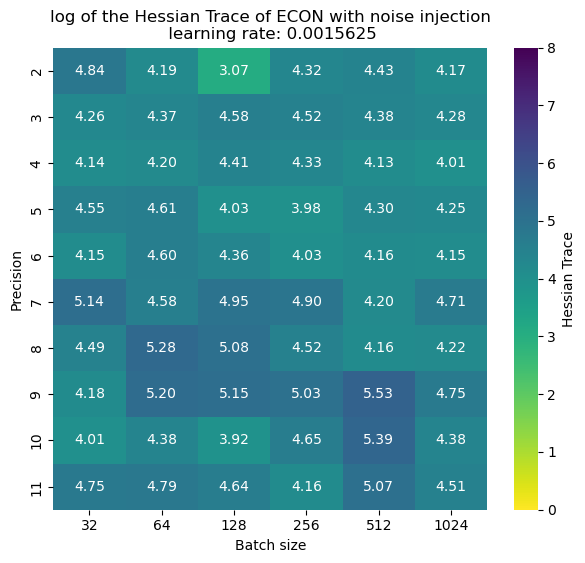

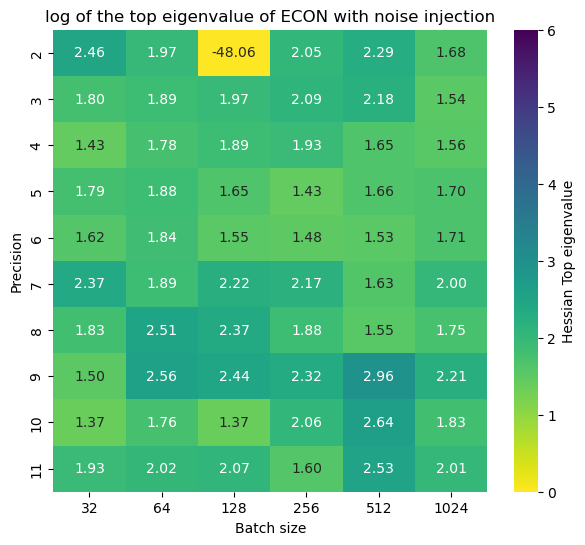

In [28]:
for aug_percentage in aug_percentages:
    for lr in learning_rates:
        trace_matrix = np.zeros((len(precisions), len(batch_sizes)))
        eigen_matrix = np.zeros((len(precisions), len(batch_sizes)))
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_AUG_{p}b/{size}/')

                result = -1
                trace = []
                eigen_value = []
                
                for i in range(1, 4):
                    try:
                        result = read_file(path, name=f"hessian_{i}", aug_percentage=aug_percentage)
                        trace.append(sum(result['trace']))
                        eigen_value.append(result['eigenvalues'][0])
                    except:
                        print("Error: cannot open the file!")
                    
                trace_matrix[x, y] = mean(trace)
                eigen_matrix[x, y] = mean(eigen_value)
                    
                
        log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
        log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
        
        log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                        index=precisions, 
                                        columns=batch_sizes)
        log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                        index=precisions, 
                                        columns=batch_sizes)
        print('-'*100)
        
        plot_2d_heatmap(log_trace_matrix, 
                        f'log of the Hessian Trace of ECON with noise injection' \
                        f'\n learning rate: {lr}', 
                        (0, 8),
                        'Batch size',
                        'Precision',
                        'Hessian Trace',
                        cmap='viridis_r')
        plot_2d_heatmap(log_eigen_matrix, 
                        f'log of the top eigenvalue of ECON with noise injection', 
                        (0, 6),
                        'Batch size',
                        'Precision',
                        'Hessian Top eigenvalue',
                        cmap='viridis_r')

## ECON with Jacobian Regularization

In [29]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
learning_rates = [0.0015625]
jreg_percentages = [0.1]

File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_2b/baseline/hessian_1_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_3b/baseline/hessian_3_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_4b/baseline/hessian_2_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_5b/baseline/hessian_2_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_6b/baseline/hessian_1_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_7b/baseline/hessian_1_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs32_lr0.0015625/ECON_JREG_8b/baseline/hessian_3_jreg_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work

/tmp/tbaldi/ipykernel_3166070/3525123268.py:26: RuntimeWarning: invalid value encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)


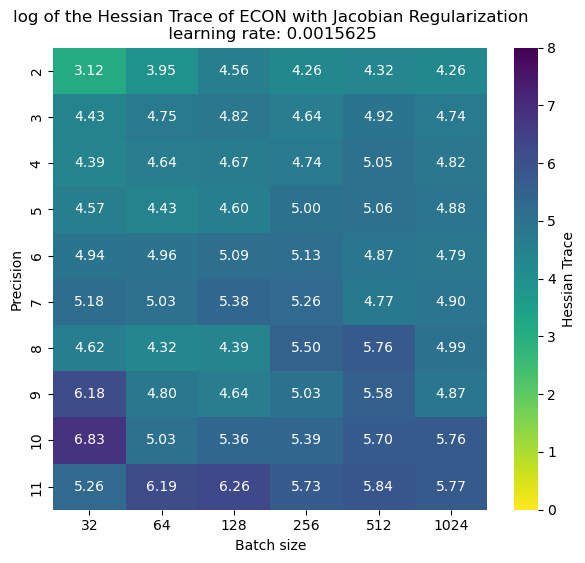

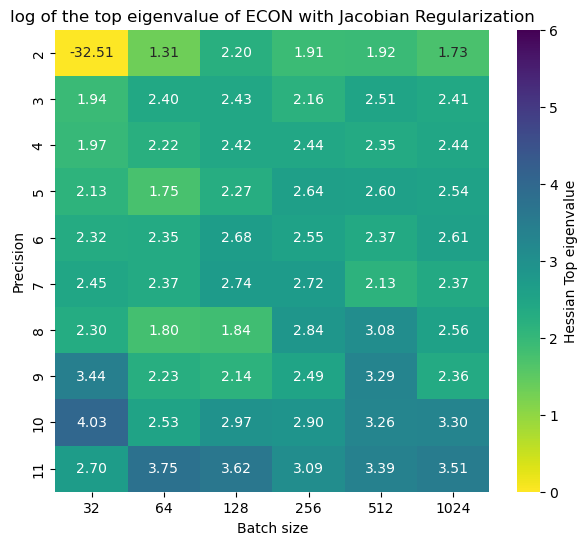

In [30]:
for jreg_percentage in jreg_percentages:
    for lr in learning_rates:
        trace_matrix = np.zeros((len(precisions), len(batch_sizes)))
        eigen_matrix = np.zeros((len(precisions), len(batch_sizes)))
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_JREG_{p}b/{size}/')

                result = -1
                trace = []
                eigen_value = []
                
                for i in range(1, 4):
                    try:
                        result = read_file(path, name=f"hessian_{i}", j_reg=jreg_percentage)
                        trace.append(sum(result['trace']))
                        eigen_value.append(result['eigenvalues'][0])
                    except:
                        print("Error: cannot open the file!")
                    
                trace_matrix[x, y] = mean(trace)
                eigen_matrix[x, y] = mean(eigen_value)
                    
                
        log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
        log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
        
        log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                        index=precisions, 
                                        columns=batch_sizes)
        log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                        index=precisions, 
                                        columns=batch_sizes)
        print('-'*100)
        
        plot_2d_heatmap(log_trace_matrix, 
                        f'log of the Hessian Trace of ECON with Jacobian Regularization' \
                        f'\n learning rate: {lr}', 
                        (0, 8),
                        'Batch size',
                        'Precision',
                        'Hessian Trace',
                        cmap='viridis_r')
        plot_2d_heatmap(log_eigen_matrix, 
                        f'log of the top eigenvalue of ECON with Jacobian Regularization', 
                        (0, 6),
                        'Batch size',
                        'Precision',
                        'Hessian Top eigenvalue',
                        cmap='viridis_r')

## ECON with pruning

In [31]:
learning_rates = [0.0015625]
batch_sizes = [512]
pruning_step = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

In [32]:
h_distribution = []
for step in pruning_step:
    for lr in learning_rates:
        for y, bs in enumerate(batch_sizes):
            for x, p in enumerate(precisions):
                path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
                if step > 0:
                    path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_PRUNE_{p}b/{size}/')
                
                trace = []
                eigen_value = []
                
                for i in range(1, 4):
                    try:
                        result = read_file(path, name=f"hessian_{i}", prune=step)
                        trace.append(sum(result['trace']))
                        eigen_value.append(result['eigenvalues'][0])
                    except:
                        print("Error: cannot open the file!")

                # build the heatmap
                h_distribution.append({
                        'precision': p, 
                        'top eigenvalue': np.log10(np.mean(eigen_value)),
                        'trace': np.log10(np.mean(trace)),
                        'batch_size': str(bs),
                        'learning_rate': str(lr),
                        'type': f"{int(step * 100)}% pruning"
                    })

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_2b/baseline/hessian_1_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_3b/baseline/hessian_1_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_4b/baseline/hessian_2_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_5b/baseline/hessian_1_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_6b/baseline/hessian_2_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_7b/baseline/hessian_3_prune_0.1.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/ECON_PRUNE_8b/baseline/hessian_3_prune_0.1.pkl)
Error: cannot open the file!
File not foun

In [33]:
h_distribution_df = pd.DataFrame(h_distribution)
h_distribution_df.to_csv("./results/econ/prune_hessian.csv", index=False)

# RN08 (TinyResNet)

In [34]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/RN08'

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


/tmp/tbaldi/ipykernel_3166070/1376024205.py:29: RuntimeWarning: divide by zero encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/1376024205.py:30: RuntimeWarning: divide by zero encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
/tmp/tbaldi/ipykernel_3166070/1376024205.py:43: RuntimeWarning: divide by zero encountered in log10
  (0, np.log10(trace_matrix.max().max())),


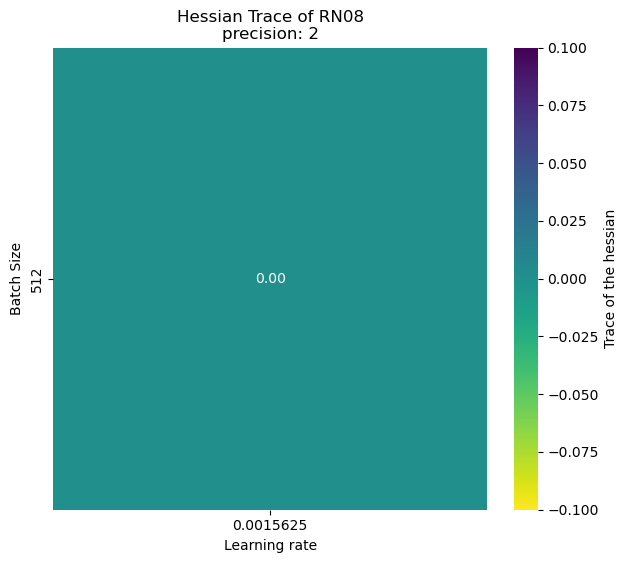

/tmp/tbaldi/ipykernel_3166070/1376024205.py:52: RuntimeWarning: divide by zero encountered in log10
  (0, np.log10(eigen_matrix.max().max())),


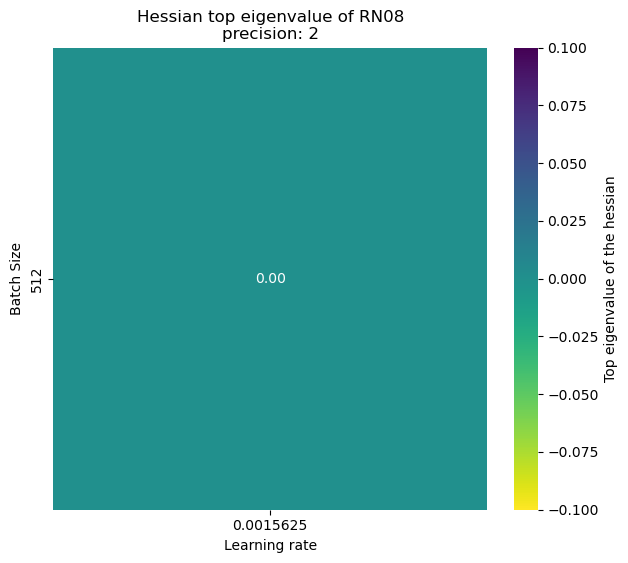

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_3b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


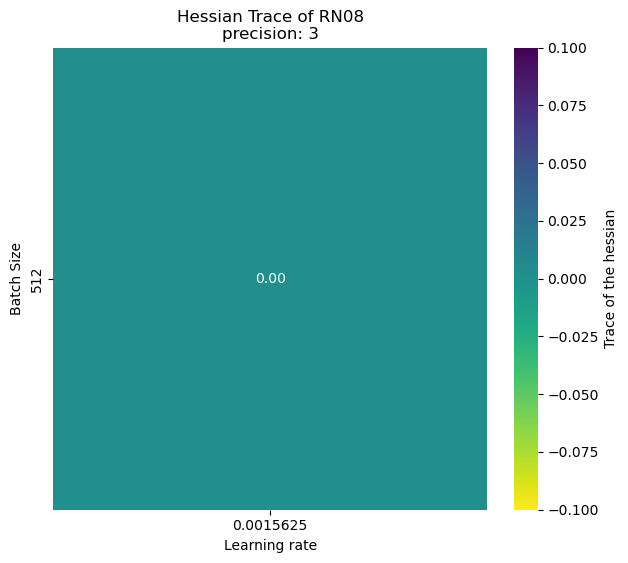

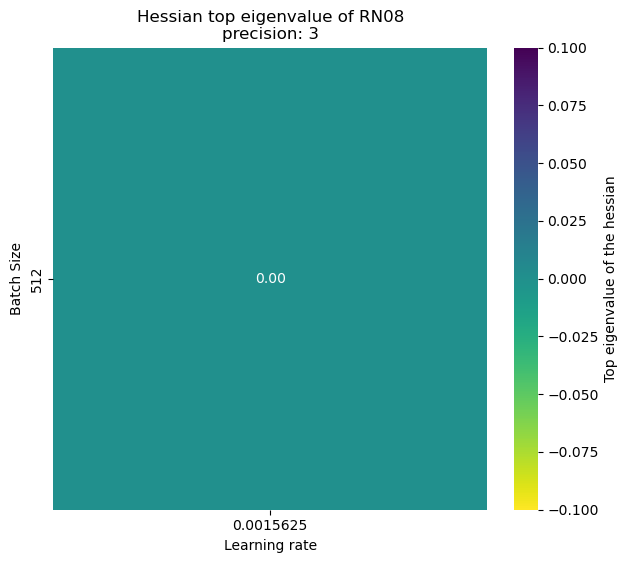

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_4b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


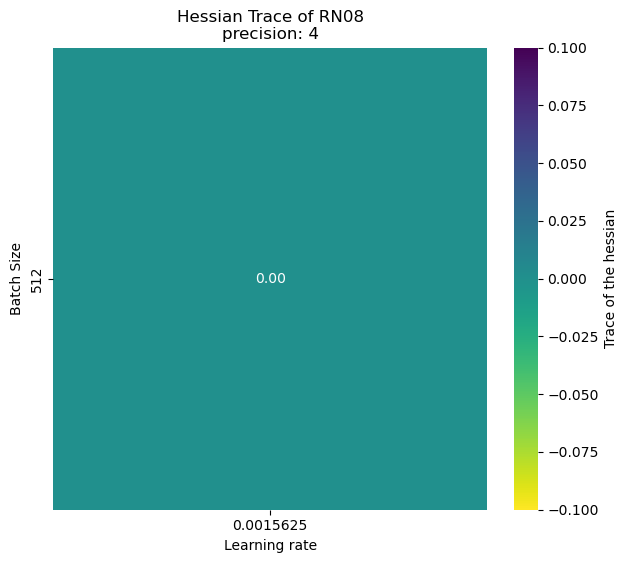

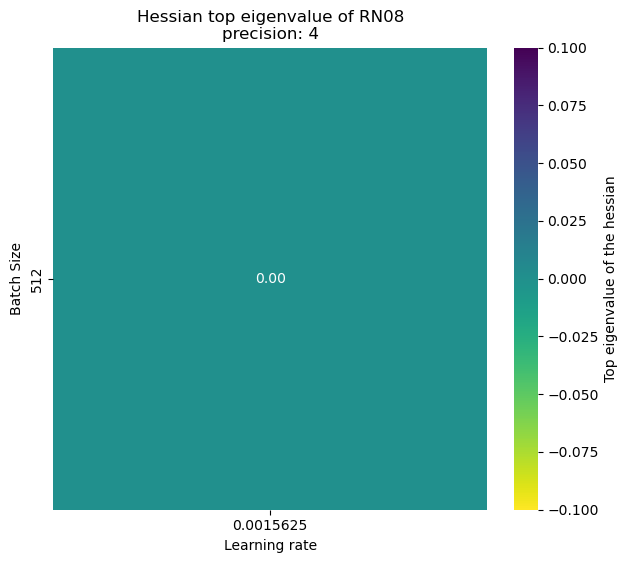

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_5b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


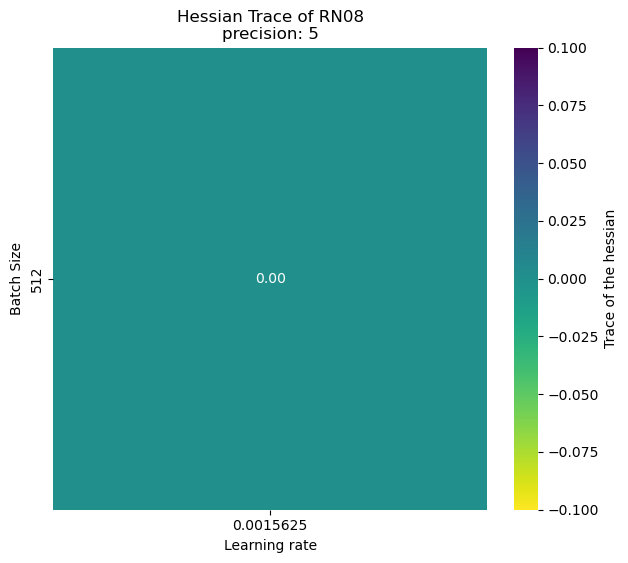

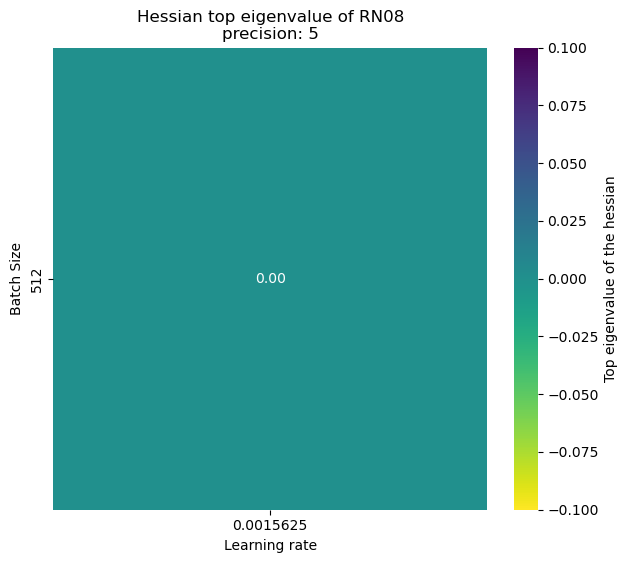

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_6b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


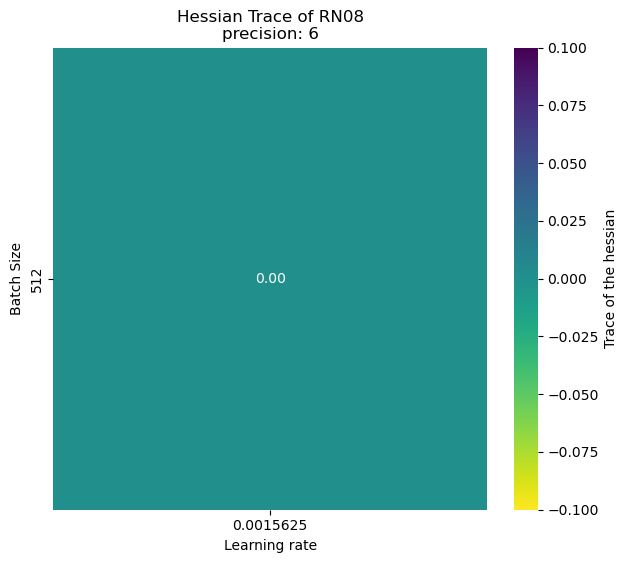

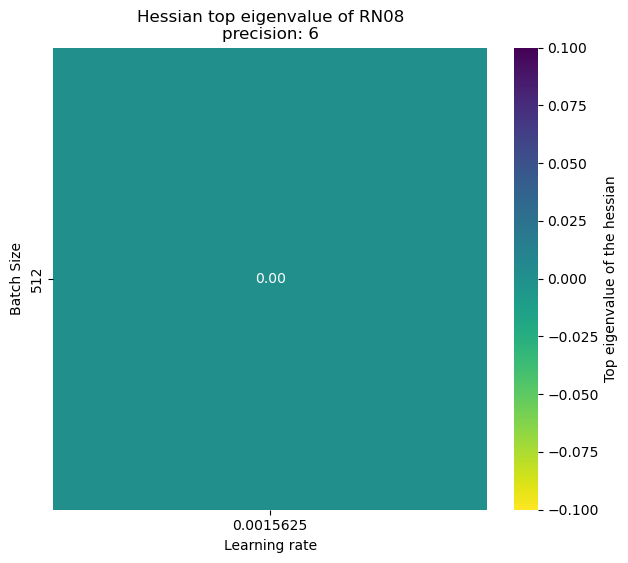

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_7b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


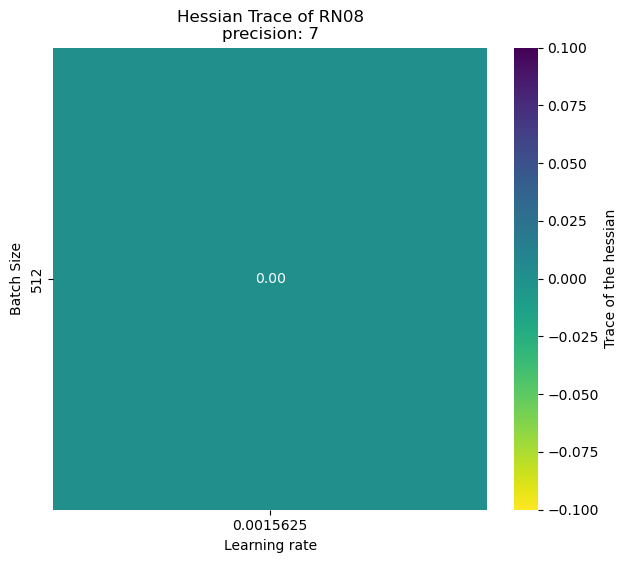

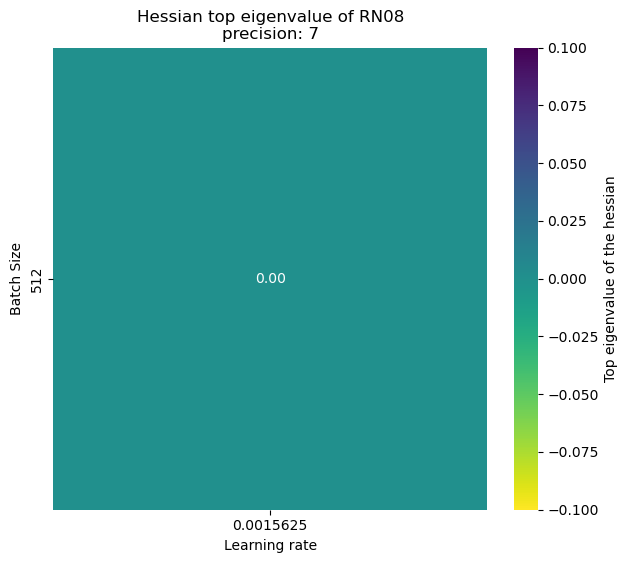

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_8b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


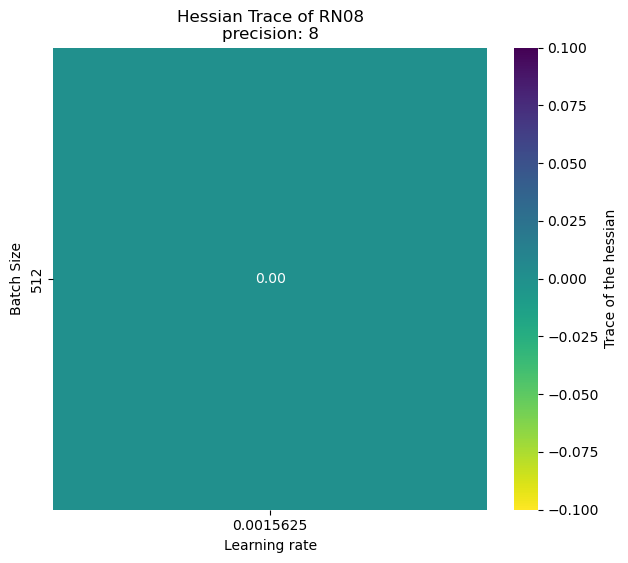

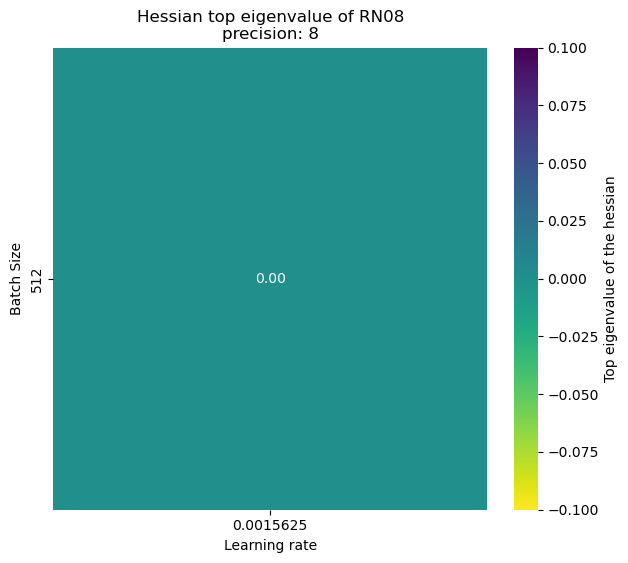

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_9b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


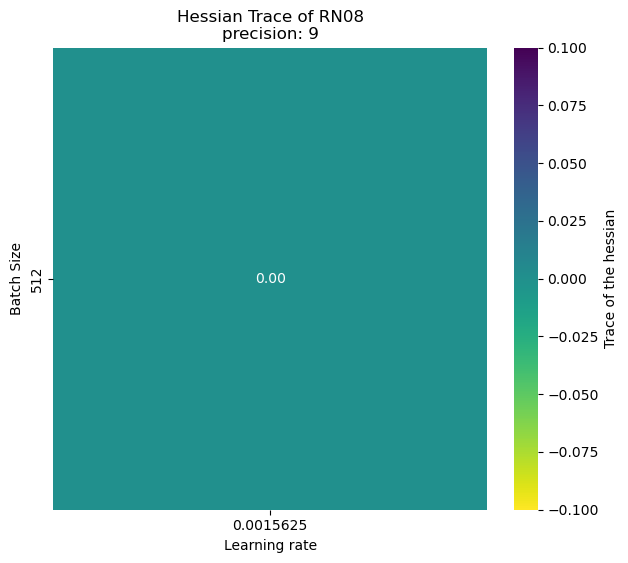

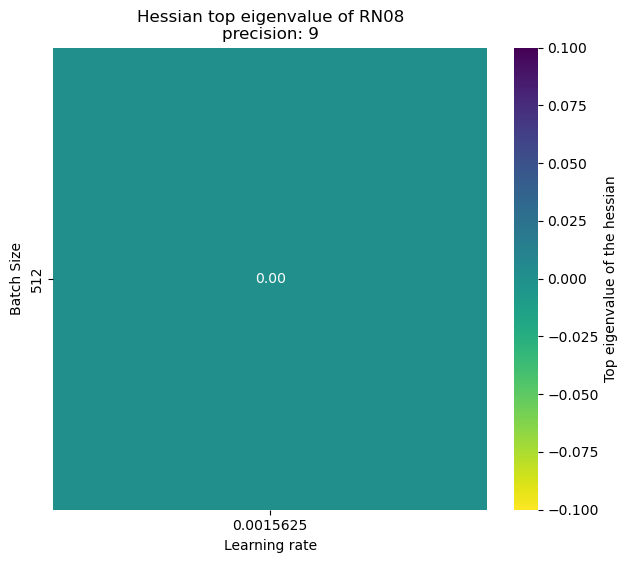

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_10b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


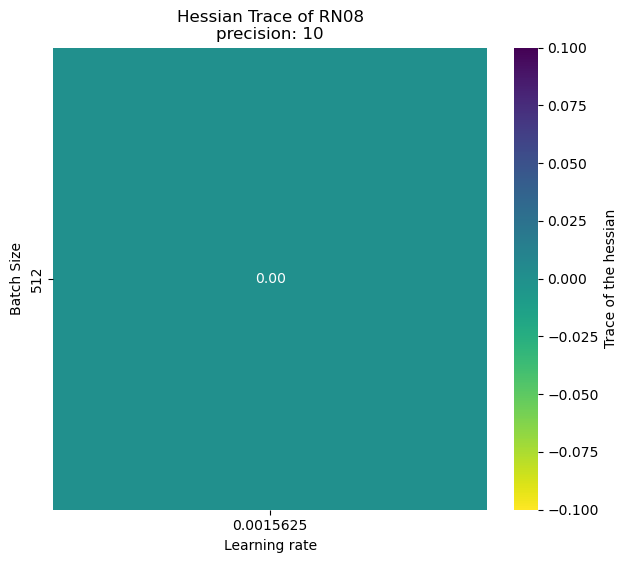

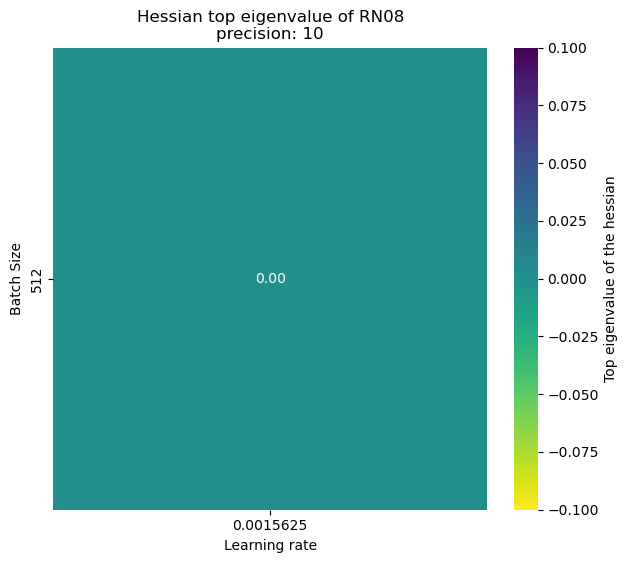

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_11b/hessian.pkl)
Error: cannot open the file!
----------------------------------------------------------------------------------------------------


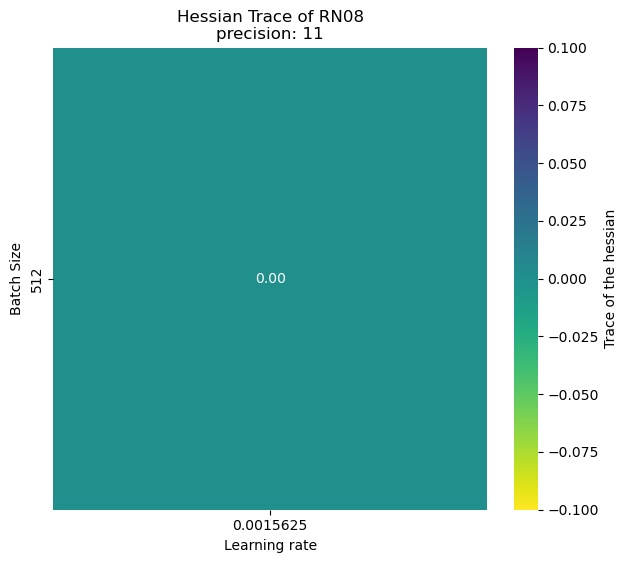

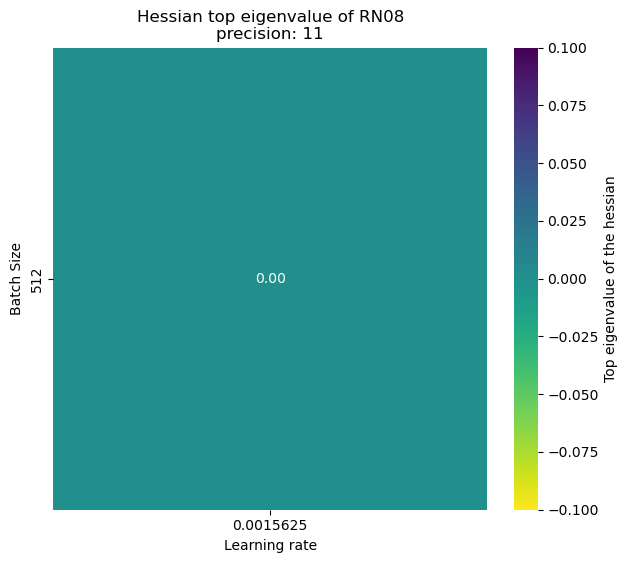

In [35]:
hessian_distribution = []
for p in precisions:
    trace_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    eigen_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            
            trace = 0
            eigen_value = 0
            try:
                result = read_file(path)
                trace = sum(result['trace'])
                eigen_value = result['eigenvalues'][0]
            except:
                print("Error: cannot open the file!")
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
            
            hessian_distribution.append({
                'precision': p, 
                'trace': trace,
                'eigenvalue': eigen_value,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
    log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
    log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
    
    log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                    index=batch_sizes, 
                                    columns=learning_rates)
    
    print('-'*100)
    
    plot_2d_heatmap(log_trace_matrix, 
                    f'Hessian Trace of RN08\nprecision: {p}', 
                    (0, np.log10(trace_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Trace of the hessian',
                    cmap='viridis_r')
    
    
    plot_2d_heatmap(log_eigen_matrix, 
                    f'Hessian top eigenvalue of RN08\nprecision: {p}', 
                    (0, np.log10(eigen_matrix.max().max())),
                    'Learning rate',
                    'Batch Size',
                    'Top eigenvalue of the hessian',
                    cmap='viridis_r')


In [36]:
hessian_distribution_df = pd.DataFrame(hessian_distribution)
hessian_distribution_df.to_csv("./results/rn08/hessian.csv", index=False)

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_3b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_4b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_5b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_6b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_7b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_8b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_9b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_10b/hessian.pkl)
Er

/tmp/tbaldi/ipykernel_3166070/4159301824.py:22: RuntimeWarning: divide by zero encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/4159301824.py:23: RuntimeWarning: divide by zero encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
/tmp/tbaldi/ipykernel_3166070/4159301824.py:35: RuntimeWarning: divide by zero encountered in log10
  (0, np.log10(trace_matrix.max().max())),


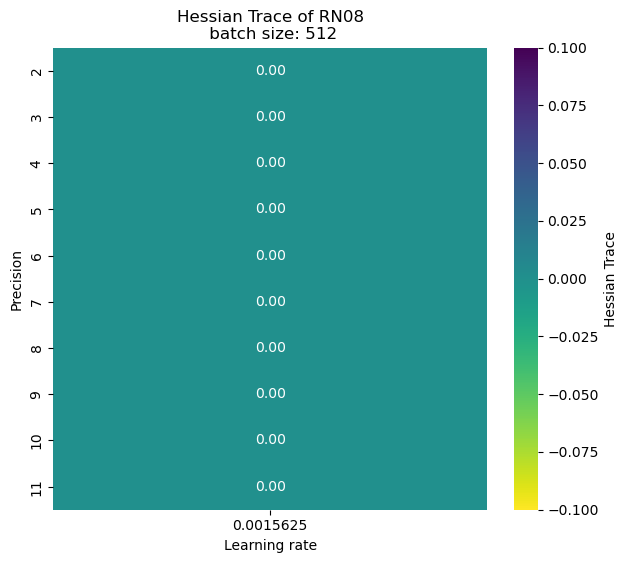

/tmp/tbaldi/ipykernel_3166070/4159301824.py:42: RuntimeWarning: divide by zero encountered in log10
  (0, np.log10(eigen_matrix.max().max())),


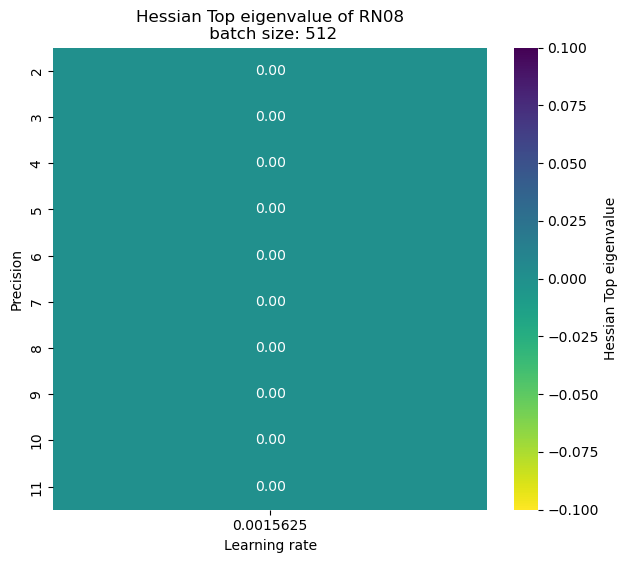

In [37]:
for bs in batch_sizes:
    trace_matrix = np.zeros((len(precisions), len(learning_rates)))
    eigen_matrix = np.zeros((len(precisions), len(learning_rates)))
    for y, lr in enumerate(learning_rates):
        for x, p in enumerate(precisions):

            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            
            trace = 0
            eigen_value = 0
            try:
                result = read_file(path)
                trace = sum(result['trace'])
                eigen_value = result['eigenvalues'][0]
            except:
                print("Error: cannot open the file!")
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
                
            
    log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
    log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
    
    log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                    index=precisions, 
                                    columns=learning_rates)
    log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                    index=precisions, 
                                    columns=learning_rates)
    print('-'*100)
    
    plot_2d_heatmap(log_trace_matrix, 
                    f'Hessian Trace of RN08\n batch size: {bs}', 
                    (0, np.log10(trace_matrix.max().max())),
                    'Learning rate',
                    'Precision',
                    'Hessian Trace',
                    cmap='viridis_r')
    plot_2d_heatmap(log_eigen_matrix, 
                    f'Hessian Top eigenvalue of RN08\n batch size: {bs}', 
                    (0, np.log10(eigen_matrix.max().max())),
                    'Learning rate',
                    'Precision',
                    'Hessian Top eigenvalue',
                    cmap='viridis_r')

File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_2b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_3b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_4b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_5b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_6b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_7b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_8b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_9b/hessian.pkl)
Error: cannot open the file!
File not found. (/data/tbaldi/work/checkpoint/bs512_lr0.0015625/RN08_10b/hessian.pkl)
Er

/tmp/tbaldi/ipykernel_3166070/1448629409.py:25: RuntimeWarning: divide by zero encountered in log10
  log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
/tmp/tbaldi/ipykernel_3166070/1448629409.py:26: RuntimeWarning: divide by zero encountered in log10
  log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)


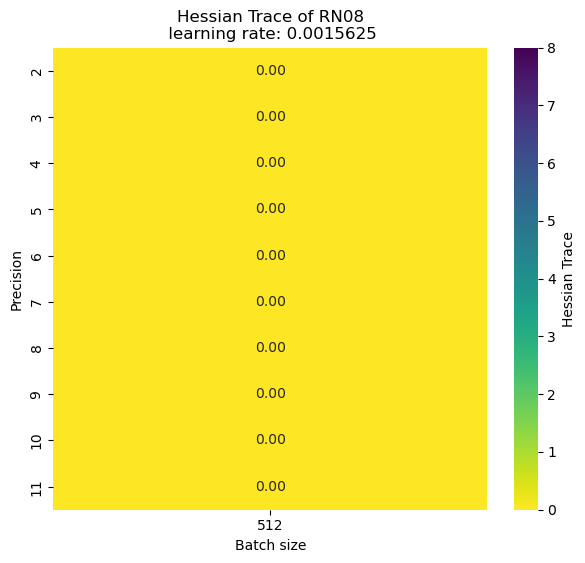

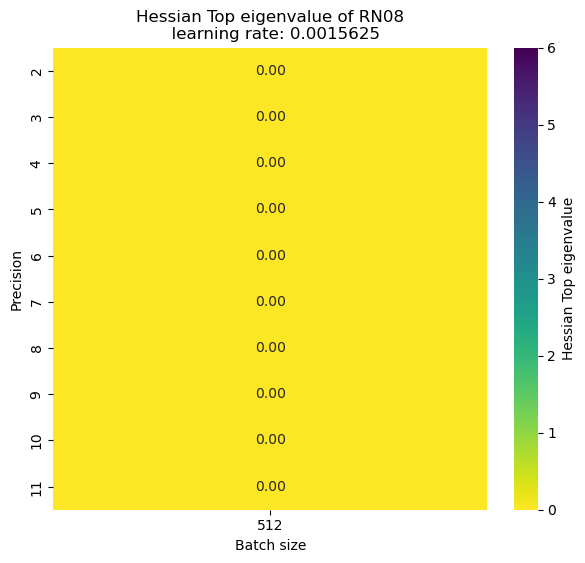

In [38]:
for lr in learning_rates:
    trace_matrix = np.zeros((len(precisions), len(batch_sizes)))
    eigen_matrix = np.zeros((len(precisions), len(batch_sizes)))
    for y, bs in enumerate(batch_sizes):
        for x, p in enumerate(precisions):
            
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            
            trace = 0
            eigen_value = 0
            try:
                result = read_file(path)
                trace = sum(result['trace'])
                eigen_value = result['eigenvalues'][0]
            except:
                print("Error: cannot open the file!")
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
                
            trace_matrix[x, y] = trace
            eigen_matrix[x, y] = eigen_value
                
            
    log_trace_matrix = np.where(trace_matrix > 0, np.log10(trace_matrix), trace_matrix)
    log_eigen_matrix = np.where(eigen_matrix > 0, np.log10(eigen_matrix), eigen_matrix)
    
    log_trace_matrix = pd.DataFrame(log_trace_matrix, 
                                    index=precisions, 
                                    columns=batch_sizes)
    log_eigen_matrix = pd.DataFrame(log_eigen_matrix, 
                                    index=precisions, 
                                    columns=batch_sizes)
    print('-'*100)
    
    plot_2d_heatmap(log_trace_matrix, 
                    f'Hessian Trace of RN08\n learning rate: {lr}', 
                    (0, 8),
                    'Batch size',
                    'Precision',
                    'Hessian Trace',
                    cmap='viridis_r')
    plot_2d_heatmap(log_eigen_matrix, 
                    f'Hessian Top eigenvalue of RN08\n  learning rate: {lr}', 
                    (0, 6),
                    'Batch size',
                    'Precision',
                    'Hessian Top eigenvalue',
                    cmap='viridis_r')